# Packages

In [1]:
import ee
import geemap

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
import matplotlib.pyplot as plt

try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

import os
os.getcwd()

'c:\\Users\\gilramolete\\OneDrive - UNIONBANK of the Philippines\\Documents 1\\Open Nighttime Lights'

# Get VIIRS data and city geometries

In [2]:
viirs = ee.ImageCollection('NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG').select('avg_rad')

select_cities = ['Berlin', 'Seoul', 'Sao Paulo']
city_geoms = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.inList('ADM1_NAME', select_cities))
city_geoms

In [4]:
def get_city_avg_rad(img):
    """Reduce our collection of geometries

    Args:
        img (_type_): _description_
    """
    return img.reduceRegions(reducer = ee.Reducer.mean(), collection = city_geoms, scale = 500)

def get_date(img):
    """Get individual image date

    Args:
        img (_type_): _description_
    """
    return img.set('date', img.date().format())

# Map these functions to our image collection
reduced_cities = viirs.map(get_city_avg_rad).flatten()
dates = viirs.map(get_date)

# Get lists
key_cols = ['ADM1_NAME', 'mean']
cities_list = reduced_cities.reduceColumns(ee.Reducer.toList(len(key_cols)), key_cols).values()
dates_list = dates.reduceColumns(ee.Reducer.toList(1), ['date']).values()

# Structure our data
df = pd.DataFrame(np.asarray(cities_list.getInfo()).squeeze(), columns = key_cols)
dates = np.asarray(dates_list.getInfo()).squeeze()

for city in select_cities:
    df.loc[df['ADM1_NAME'] == city, 'dates'] = dates

# Convert date and set index
df['dates'] = pd.to_datetime(df['dates'])
df.set_index('dates', inplace = True)

# We'll also convert our mean datatype to float
df['mean'] = df['mean'].astype(float)
df

ADM1_NAME       mean
dates                           
2014-01-01  Sao Paulo   1.792589
2014-01-01     Berlin  18.209309
2014-01-01      Seoul  48.085756
2014-02-01  Sao Paulo   1.764743
2014-02-01     Berlin  15.194246
...               ...        ...
2023-09-01     Berlin  12.968648
2023-09-01      Seoul  53.214502
2023-10-01  Sao Paulo   1.972315
2023-10-01     Berlin  12.500142
2023-10-01      Seoul  51.910005

[354 rows x 2 columns]

Does anything seem odd about these outliers? What do we know about our underlying geometries (i.e. are we positive they are comparable across cities?)

# Compare time series

We can plot our time series. Because we chose a scaled metric (mean radiance, instead of SOL), these data are standardized and we can compare them directly.

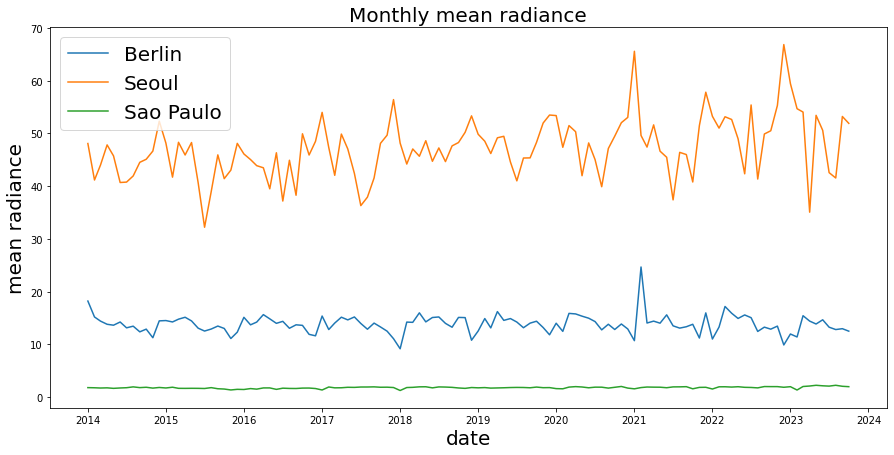

In [5]:
fig, ax = plt.subplots(figsize = (15, 7))

for city in select_cities:
    data = df.loc[df['ADM1_NAME']==city, :]
    sns.lineplot(data = data, x = data.index, y = 'mean', label = city, ax = ax)

ax.set_ylabel('mean radiance', fontsize = 20)
ax.set_xlabel('date', fontsize = 20)
ax.legend(fontsize = 20)
ax.set_title('Monthly mean radiance', fontsize = 20)

plt.show()

Comparing these three cities, we first see the order of magnitude, such that Seoul has the brightest avg radiance (per pixel per month), followed by Berlin, with Sao Paulo much lower (recall our note earlier about data consistency…perhaps there’s an issue with the size of the area being compared? Probably another reason to scale the data by area…)

We dont see dramatic trends of growth or decline for any of these cities.

But can we quantify this?

# Calculate rate of change

We’ll get the rate of change for these cities to quantify any general trends from the first month to the last of the series.

Becuase we already have our data in a dataframe, we could just calculate the rate of change based on our avg radiance per city…but that’s losing a lot of information.

The advantage of calculating rate of change directly on the raster files is that we get the per-pixel rate of change directly – and then we reduce our data to an average or a sum for our region in order to plot or analyze it.

This may seem like a subtle change, but for larger areas (including large cities), there might be some pixels that see dramatic change over time that are important to calculate before aggregating everything to a citywide average. Calculating the citywide average first for each time period may cause us to lose sensitivity to such spatial dynamics.

With GEE its quite easy to reduce our `ImageCollection` to a representation of the rate of change. Then we can either examine the plot, or perhaps make histograms. First, let's get the rate of change.

In [6]:
# Get first image by sorting by image "time_end"
first_img = viirs.sort('system:time_end').first()

# Get last image by reverse sorting
last_img = viirs.sort('system:time_end', False).first()

# Get total periods (months) in our series
periods = int(viirs.size().getInfo())
print(f'The series covers {periods} months')

The series covers 118 months


In [7]:
viirs_slope = (last_img.subtract(first_img)).divide(periods)
viirs_slope

Let’s compare cities by getting a histogram that represents the distribution of the change in nightime lights per month (rate of change) for each city.

In [8]:
roc_data = {}

for city in select_cities:
    try:
        geom = city_geoms.filter(ee.Filter.eq('ADM1_NAME', city)).geometry()
        roc_data[city] = np.array(viirs_slope.sampleRectangle(region = geom).get('avg_rad').getInfo())
    except:
        print(f'{city} failed due to pixel limits')

Sao Paulo failed due to pixel limits


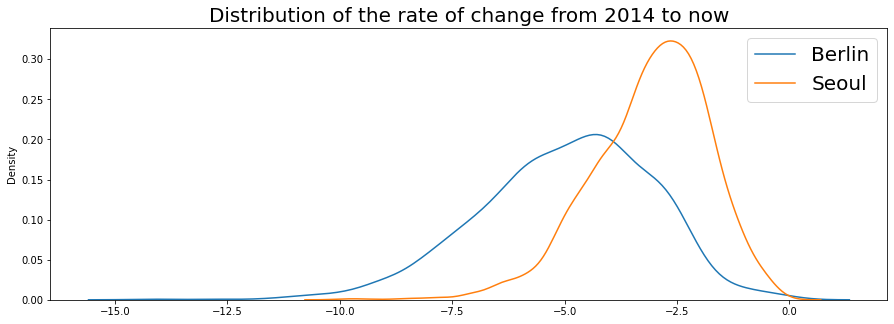

In [9]:
# We'll use the logscale
fig, ax = plt.subplots(figsize = (15, 5))

# Iterate through each key-value pair 
for k, v in roc_data.items():
    sns.kdeplot(np.log(v).flatten(), label = k, legend = True, ax = ax)

ax.legend(fontsize = 20)
ax.set_title('Distribution of the rate of change from 2014 to now', fontsize = 20)

plt.show()

Both cities are showing declines, interestingly, although the decline in nighttime lights for Berlin is sharper and larger than that of Seoul it appears…and Seoul has a wider variance with more pixels appearing to show some positive growth as well.

Let’s take a quick look at the rasters…

In [10]:
city = 'Berlin'

berlinMap = geemap.Map()
geom = city_geoms.filter(ee.Filter.eq('ADM1_NAME', city)).geometry()

berlinMap.centerObject(geom, zoom = 10)
berlinMap.addLayer(viirs_slope.clip(geom), {'min': -1, 'max': 1}, city, opacity = 0.7)
berlinMap

Map(center=[52.50307584767821, 13.398289416023259], controls=(WidgetControl(options=['position', 'transparent_…

In [12]:
city = 'Seoul'
seoulMap = geemap.Map()
geom = city_geoms.filter(ee.Filter.eq('ADM1_NAME',city)).geometry()
seoulMap.centerObject(geom, zoom = 11)
seoulMap.addLayer(viirs_slope.clip(geom), {'min': -1., 'max': 1}, city, opacity=0.7)
seoulMap

Map(center=[37.53803118323625, 127.00584943229947], controls=(WidgetControl(options=['position', 'transparent_…

In [13]:
city = 'Sao Paulo'
spMap = geemap.Map()
geom = city_geoms.filter(ee.Filter.eq('ADM1_NAME',city)).geometry()
spMap.centerObject(geom, zoom = 6)
spMap.addLayer(viirs_slope.clip(geom), {'min': -1. , 'max': 1},city, opacity = 0.7)
spMap

Map(center=[-22.26179743862149, -48.74090536767993], controls=(WidgetControl(options=['position', 'transparent…

First note that we really should be careful comparing…apparently our Admin levels mean “city” for Seoul and Berlin but “province/state” for Sao Paulo! An analysis of these cities must use standard definitions of area. You can research this, but visualizing data quickly is a good empirical gut-check about your research design and assumptions.

Aside from that… With higher resolution you can see differentation at the neighborhood…and all cities seem to show various patterns of growth and decline, perhaps indicating pockets of construction or development.

We’re using May 2020 as our most recent image – and this is very likely impacted by the effects of COVID-19. Would looking at the rate of change for these cities using different time periods make any difference?